# Bigram Model Examples

This notebook builds simple bigram models from the text declared in the next paragraph. It preprocesses the text by removing punctuation, tokenizing it into words, and splitting the text into lines. The model then generates new random lines based on the input text, using weighted random selection to choose words.

This is a generative model, in the technical sense that the statistical model used to describe the input dataset can be sampled randomly, and used to generate new examples like those the training set. What shared features make two samples alike in these models is encoded in the training / modeling process: in the case of a bigram model, two samples are alike if they have lots of pairs of words in common, so the phrases _"This is a great language model"_ and _"This is not a great language model"_ would be considered very much alike.

Generative models can be very powerful, but "generative" in machine learning doesn't mean imaginative, or generally useful, or sophisticated and new. It just means that the statistical data model can be coupled with a random number generator to propose training samples which look (to the model) like the ones it was given to begin with. 

This notebook is released under the BSD License. See the full license at the end.

In [142]:
# Input texts: feel free to change and experiment with rerunning the notebook.
text = """
In the beginning God created the heaven and the earth.
And the earth was without form, and void; and darkness was upon the face of the deep.
And the Spirit of God moved upon the face of the waters.
And God said, Let there be light: and there was light.
And God saw the light, that it was good: and God divided the light from the darkness.
"""

text = """
Never gonna give you up
Never gonna let you down
"""

In [143]:
import re
import random
from collections import defaultdict, Counter
from typing import List, Dict, DefaultDict


START_TOKEN = "<START>"
END_TOKEN = "<END>"


# Tokenizes a single line, removes punctuation, and converts to lowercase.
def tokenize_line(line: str) -> List[str]:
    clean_line = re.sub(r'[^\w\s]', '', line.lower())
    return clean_line.split()

# Creates a bigram model, counting occurrences of word pairs, including <START> and <END> tokens.
def build_bigram_model(tokenized_lines: List[List[str]]) -> DefaultDict[str, Dict[str, int]]:
    bigram_model = defaultdict(lambda: defaultdict(int))
    
    # Iterate over each tokenized line and create bigrams including <START> and <END> tokens
    for line in tokenized_lines:
        line = [START_TOKEN] + line + [END_TOKEN]
        
        for i in range(len(line) - 1):
            current_word = line[i]
            next_word = line[i + 1]
            bigram_model[current_word][next_word] += 1
    
    return bigram_model

# Selects the next word based on weighted random selection from word counts.
def weighted_random_choice(word_counts: Dict[str, int]) -> str:
    total = sum(word_counts.values())
    rand_val = random.uniform(0, total)
    cumulative = 0
    for word, count in word_counts.items():
        cumulative += count
        if rand_val <= cumulative:
            return word

# Generates a random line from the bigram model, stopping when <END> is selected.
def generate_line(bigram_model: DefaultDict[str, Dict[str, int]], start_word: str = START_TOKEN) -> str:
    current_word = start_word
    result = [] if start_word == START_TOKEN else [current_word]
    while current_word != END_TOKEN:
        next_word = weighted_random_choice(bigram_model[current_word])
        result.append(next_word)
        current_word = next_word
    return ' '.join(result[:-1])

# Finds the most common words in the token list, excluding <START> and <END>.
def get_most_common_words(tokenized_lines: List[List[str]], n: int = 3) -> List[str]:
    tokens = [token for line in tokenized_lines for token in line]  # Flatten tokenized lines
    word_counts = Counter(tokens)
    most_common_words = [word for word, count in word_counts.most_common() if word not in [START_TOKEN, END_TOKEN]]
    return most_common_words[:n]

# Tokenize the text line by line
tokenized_lines = [tokenize_line(line) for line in text.strip().splitlines()]

# Build the bigram model directly from the tokenized lines
bigram_model = build_bigram_model(tokenized_lines)

In [144]:
# This cell generates some new lines of text.
print("Generated lines:")
for _ in range(8):
    print(generate_line(bigram_model))


Generated lines:
never gonna let you down
never gonna let you up
never gonna let you up
never gonna let you up
never gonna give you down
never gonna let you up
never gonna give you up
never gonna let you down


In [145]:
# This paragraph prints the bigram model as a word: word, frequency data structure.
import pandas as pd
from typing import Dict

pd.set_option('display.max_colwidth', None)

# Function to convert the bigram model to a more structured table format
def bigram_model_to_structured_table(bigram_model: Dict[str, Dict[str, int]]) -> pd.DataFrame:
    table = []

    # Loop through the bigram model and collect the data
    for word, next_words in bigram_model.items():
        # Format next words with their counts in 'word: count' format, sorted by count
        next_word_list = ', '.join([f"{next_word}: {count}" 
                                    for next_word, count in sorted(next_words.items(), key=lambda x: x[1], reverse=True)])
        table.append([word, sum(next_words.values()), next_word_list])

    # Create a DataFrame with separate columns for word, total frequency, and the formatted next words
    df = pd.DataFrame(table, columns=['Word', 'Total Frequency', 'Next Words (Counts)'])
    
    # Sort the DataFrame by the total frequency of next words (in descending order)
    df = df.sort_values(by='Total Frequency', ascending=False)
    
    return df

# Display the bigram model as a more structured table
bigram_model_to_structured_table(bigram_model)


,Word,Total Frequency,Next Words (Counts)
0,<START>,2,never: 2
1,never,2,gonna: 2
2,gonna,2,"give: 1, let: 1"
4,you,2,"up: 1, down: 1"
3,give,1,you: 1
5,up,1,<END>: 1
6,let,1,you: 1
7,down,1,<END>: 1


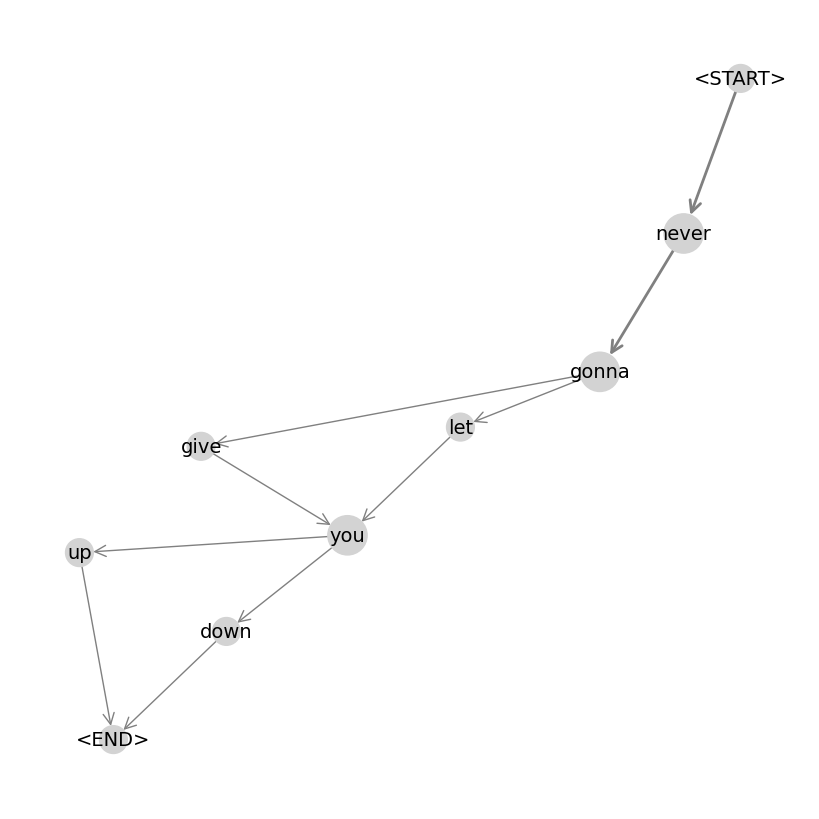

In [146]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import numpy as np

# Function to check and adjust overlapping nodes by pushing them away from the next nearest
def adjust_positions(pos, min_distance=0.5):
    """Check for overlapping nodes and move them apart if necessary."""
    new_pos = pos.copy()  # Create a copy of the original positions
    for node1 in new_pos:
        for node2 in new_pos:
            if node1 != node2:
                # Calculate the Euclidean distance between the nodes
                dist = np.linalg.norm(new_pos[node1] - new_pos[node2])
                if dist < min_distance:  # If the nodes are too close, move them apart
                    direction = new_pos[node1] - new_pos[node2]
                    direction = direction / np.linalg.norm(direction)  # Normalize direction
                    # Push node1 away from node2
                    new_pos[node1] += direction * (min_distance - dist)
    return new_pos

# Function to visualize the bigram model with proportional node sizes and edge thickness
def visualize_bigram_model_with_frequency(bigram_model):
    G = nx.DiGraph()  # Create a directed graph
    word_frequencies = defaultdict(int)  # To store the total frequency of each word

    # Add edges from the bigram model to the graph and calculate word frequencies
    for current_word, next_words in bigram_model.items():
        for next_word, count in next_words.items():
            G.add_edge(current_word, next_word, weight=count)
            word_frequencies[current_word] += count
            word_frequencies[next_word] += count

    pos = nx.kamada_kawai_layout(G)

    # Adjust positions to avoid overlap. Number of iterations is chosen manually.
    for _ in range (10):
        pos = adjust_positions(pos)

    # Set node sizes based on word frequencies (larger for more frequent words)
    node_sizes = [word_frequencies[node] * 200 for node in G.nodes()]

    # Get the edge weights to use them as thickness (make them proportional to counts)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Draw the graph
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightgray', font_size=14,
            edge_color='gray', arrows=True, 
            arrowstyle='->', arrowsize=20, node_size=node_sizes, 
            width=edge_weights)  # Set width proportional to the edge weight

    plt.show()

# Sample visualization of the bigram model
visualize_bigram_model_with_frequency(bigram_model)


If you find the rest of the chorus to "Never Gonna Give You Up", replace the text and the beginning of this notebook, and rerun everything, you should get a gameboard something like this, and can enjoy inventing new song lyrics!

![Rick Rolling Board Game](./rick_roll.png "Rick Rolling Board Game")


BSD 3-Clause License

Copyright (c) 2024, Dominic Widdows and Trevor Cohen.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.